In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
sns.set_theme()
sns.set_style('darkgrid')
sns.set(rc={
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'axes.titlepad': 10,
    'xtick.labelsize': 10,
    'xtick.color': '#002060',
    'ytick.labelsize': 10,
    'ytick.color': '#002060',
    'axes.labelcolor': '#002060',
    'axes.titlecolor': '#002060',
    "figure.dpi":100, 
    'savefig.dpi':250,
    'figure.facecolor': '#f2f2f200'
    }) 

In [3]:
dd = pd.read_csv("data/dd.csv")
hd = pd.read_csv("data/hd.csv")

In [4]:
dd.head()

,date,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,count,season,rain,snow,israin,issnow
0,2011-01-01,0,1,0,6,0,2,0.344167,0.363625,0.913930,0.160446,331,654,985,3,0.125,0.0,1,0
1,2011-01-02,0,1,0,0,0,2,0.363478,0.353739,0.678024,0.248539,131,670,801,3,0.150,0.0,1,0
2,2011-01-03,0,1,0,1,1,1,0.196364,0.189405,0.236453,0.248309,120,1229,1349,3,0.000,0.0,0,0
3,2011-01-04,0,1,0,2,1,1,0.200000,0.212122,0.445402,0.160296,108,1454,1562,3,0.000,0.0,0,0
4,2011-01-05,0,1,0,3,1,1,0.226957,0.229270,0.467980,0.186900,82,1518,1600,3,0.000,0.0,0,0


<Axes: >

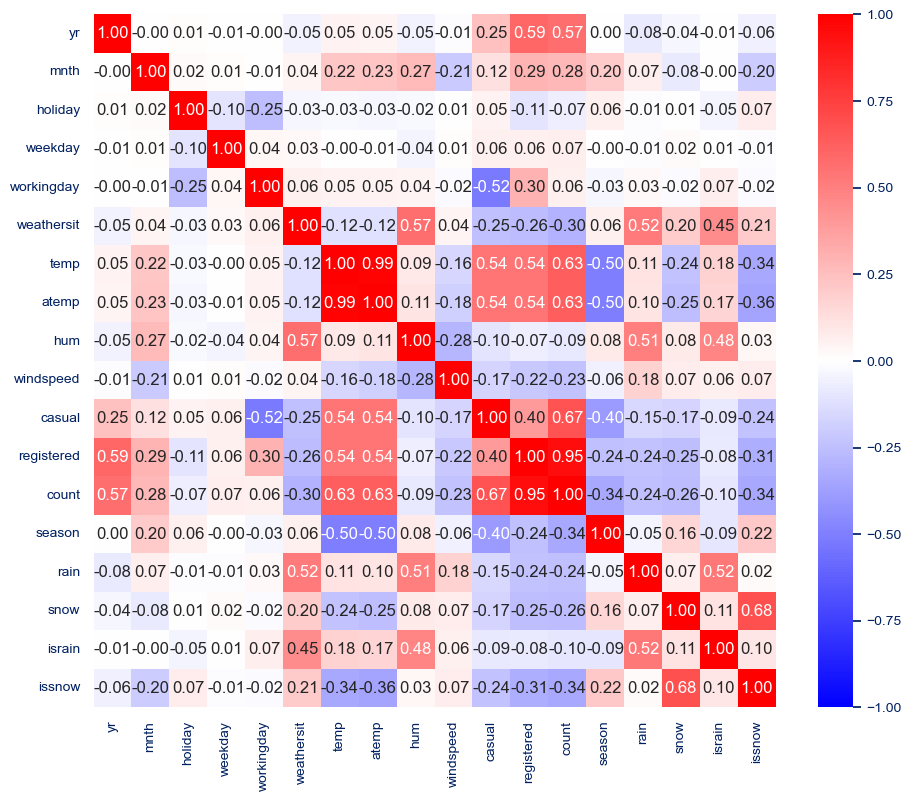

In [6]:
fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(
        dd.corr(numeric_only=True),  
        annot=True,
        fmt=".2f",
        cmap="bwr",
        # mask=mask,
        vmin=-1,
        vmax=1,
)

<Axes: >

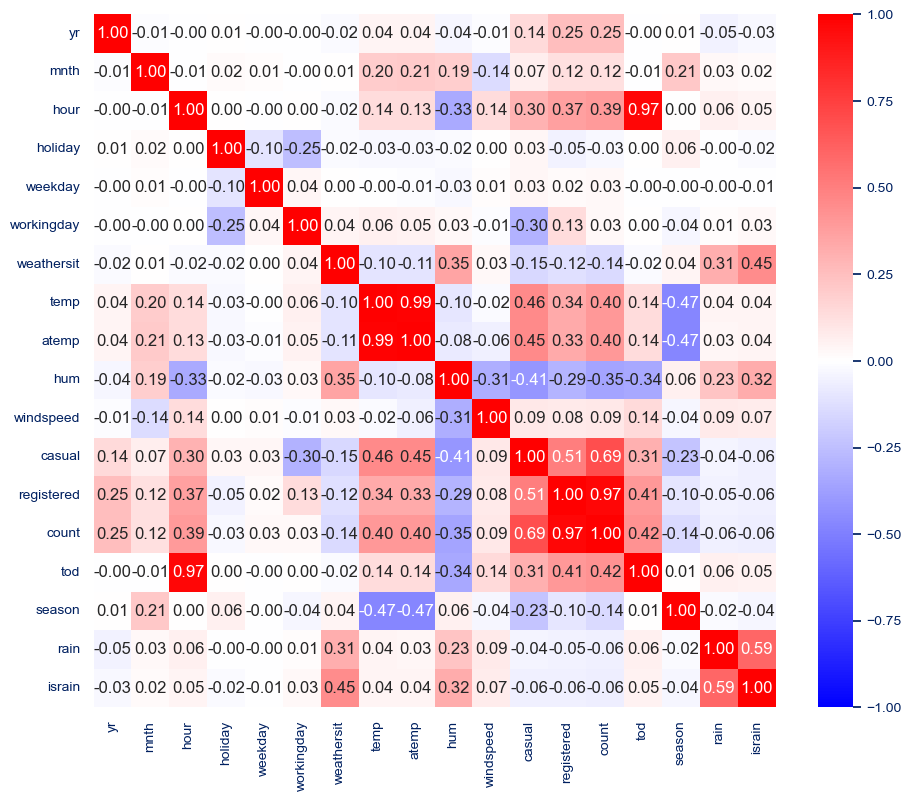

In [7]:
fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(
        hd.corr(numeric_only=True),
        annot=True,
        fmt=".2f",
        cmap="bwr",
        # mask=mask,
        vmin=-1,
        vmax=1,
)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'casual'), Text(0, 1.5, 'registered'), Text(0, 2.5, 'count')])

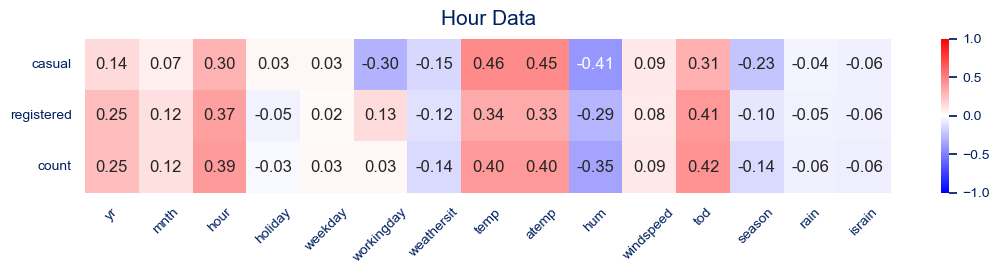

In [22]:
fig, ax = plt.subplots(figsize=(13, 2))

sns.heatmap(
        hd.corr(numeric_only=True).iloc[11:14, np.r_[0:11, 14:18]],  
        annot=True,
        fmt=".2f",
        cmap="bwr",
        # mask=mask,
        vmin=-1,
        vmax=1,
)

plt.title('Hour Data')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

In [8]:
hd_enc = pd.get_dummies(hd, columns=["season", "tod"], dtype=int).drop(
    [
        "mnth",
        "hour",
        "holiday",
        "weekday",
        "weathersit",
        "atemp",
        "israin",
        "datetime",
    ],
    axis=1,
)
dd_enc = pd.get_dummies(dd, columns=["season"], dtype=int).drop(
    [
        "mnth",
        "holiday",
        "weekday",
        "weathersit",
        "atemp",
        "israin",
        "date",
        "issnow",
        "snow",
    ],
    axis=1,
)

In [10]:
dd_enc.describe()

,yr,workingday,temp,hum,windspeed,casual,registered,count,rain,season_0,season_1,season_2,season_3
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.500684,0.683995,0.495385,0.590669,0.190486,848.176471,3656.172367,4504.348837,0.117244,0.251710,0.251710,0.248974,0.247606
std,0.500342,0.465233,0.183051,0.188463,0.077498,686.622488,1560.256377,1937.211452,0.239732,0.434293,0.434293,0.432715,0.431917
min,0.000000,0.000000,0.059130,0.000000,0.022392,2.000000,20.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.337083,0.465449,0.134950,315.500000,2497.000000,3152.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.498333,0.591817,0.180975,713.000000,3662.000000,4548.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.655417,0.730706,0.233214,1096.000000,4776.500000,5956.000000,0.105000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,0.861667,1.000000,0.507463,3410.000000,6946.000000,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
def linreg(data, target, feature, ax):
    '''Function for bulding linear regression model and plotting the results'''
    X = np.array(data[feature]).reshape((-1, 1))    
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sns.scatterplot(x=X_test.reshape(1, -1)[0], y=y_test, label='Actual', ax=ax)
    sns.lineplot(x=X_test.reshape(1, -1)[0], y=y_pred, color="r", linewidth=2, label='Regression Line', ax=ax)
    ax.set_xlabel(feature)

In [27]:
def poly_feature_plot(data, exclude, target, feature, degree, ax):
    '''Function for building a polynomail regression model for one feature and plotting the results'''
    # Extract predictors and target variable
    X = data.drop(exclude, axis=1)
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Fit polynomial regression model for the current independent variable
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train[[feature]].values)
    X_test_poly = poly.transform(X_test[[feature]].values)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predictions on the test set for the current independent variable
    y_pred = model.predict(X_test_poly)

    plt.figure(figsize=(8, 6))

    # Create a scatter plot of actual vs. predicted values for the current independent variable
    sns.scatterplot(
        x=X_test[feature], y=y_test, label="Actual", color="b", ax=ax
    )
    sns.scatterplot(
        x=X_test[feature], y=y_pred, color="red", ax=ax
    )

    # Generate values for the current independent variable to plot the polynomial regression line
    x_range = np.linspace(
        X[feature].min(), X[feature].max(), 100
    )
    x_range_poly = poly.transform(x_range.reshape(-1, 1))
    y_range_pred = model.predict(x_range_poly)

    sns.lineplot(x=x_range, y=y_range_pred, label="Regression Line", color="green", ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel("count")
    ax.legend()
    ax.set_title("Polynomial Regression Line for " + feature)

In [28]:
def plot_residuals(type, X_test, feature, residuals):
  
  x = X_test if type == 'line' else X_test[feature]
  
  # Create a scatter plot of residuals against X
  fig, ax = plt.subplots(figsize=(6, 6))
  plt.scatter(x, residuals, edgecolors='white', linewidths=0.5)
  ax.set_xlabel("Independent Variable (X)")
  ax.set_ylabel("Residuals")
  ax.set_title("Residuals Plot")
  ax.axhline(0, color='red', linestyle='--')  # Add a horizontal line at y=0
  plt.show()

In [29]:
def reg(r_type, data, exclude, target, feature="temp", do_rfe=False, do_vif=False, pos_target=True):
    '''Function for building one of 3 regression model (linear, multiple, polynomial) and plotting the results'''
    if r_type == "line":
        model_name = 'Linear Regression'
        X = np.array(data[feature]).reshape((-1, 1))
    else:
        X = data.drop(exclude, axis=1)
    y = data[target]

    if r_type == "multi":
        model_name = 'Multiple Linear Regression'

    # Data spitting
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()

    # Model training
    if r_type == "poly":
        model_name = 'Polynomial Regression'
        degree = 3
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        poly_features = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        model.fit(poly_features, y_train)
        y_pred = model.predict(X_test_poly)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    if pos_target: y_pred[y_pred < 0] = 0

    print(f"*** {model_name} ***")

    # Metrics and Scores
    print(f">>> {target.capitalize()}   ", "\n")
    mse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 3)
    if mape > 1000:
        mape = '-'
    r2 = r2_score(y_test, y_pred)
    print("Root Mean Squared Error:        ", round(mse, 3))
    print("Mean Absolute Error:            ", round(mae, 3))
    print("Mean Absolute Percentage Error: ", mape)
    print("R-Squared:                      ", round(r2, 3), '\n')
    
    # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    if do_vif:
        vif = pd.DataFrame()
        vif['Features'] = X_train.columns
        vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
        vif['VIF'] = round(vif['VIF'], 2)
        vif = vif.sort_values(by = "VIF", ascending = False)
        display(vif)

    # Recursive Feature Elimination Ranking
    if r_type != "line" and do_rfe:
        rfe = RFE(model)
        rfe = rfe.fit(X_train, y_train)
        rfe_rank = list(zip(X_train.columns, rfe.support_, rfe.ranking_))
        display(
            pd.DataFrame(rfe_rank, columns=["Feature", "Support", "Ranking"]).sort_values(
                by="Ranking"
            )
        )
    # Slope and Intercept
    if r_type != 'poly':
        slope = model.coef_[0]
        c = model.intercept_
        print("Slope (Coefficient):            ", round(slope, 3))
        print("Intercept:                      ", round(c, 3))

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    if r_type == "line":
        sns.scatterplot(x=X_test.reshape(1, -1)[0], y=y_test, label='Actual', ax=ax[0])
        sns.lineplot(
            x=X_test.reshape(1, -1)[0], y=y_pred, color="r", linewidth=2, label='Regression Line', ax=ax[0]
        )
        ax[0].set_xlabel(feature)
    elif r_type == "multi":
        sns.scatterplot(x=X_test[feature], y=y_pred, color='#eb403477', label='Predicted', ax=ax[0])
        linreg(data, target, feature, ax[0])
    else:
        sns.scatterplot(x=X_test[feature], y=y_pred, color='#eb403477', label= 'Predicted', ax=ax[0])
        poly_feature_plot(data, exclude, target, feature, degree, ax[0])
        ax[0].set_title('')

    sns.scatterplot(x=y_test, y=y_pred, color="g", ax=ax[1])
    ax[1].set_xlabel("Actual Count")
    ax[1].set_ylabel("Predicted Count")
    xy_max = max(max(ax[1].get_xticks()), max(ax[1].get_yticks()))
    if pos_target: 
        xy_min = 0
    else:
        xy_min = min(min(ax[1].get_xticks()), min(ax[1].get_yticks()))
    r = xy_max / 10
    ax[1].axhline(0, color='#303030aa', linewidth=0.5, linestyle='--')
    ax[1].axvline(0, color='#303030aa', linewidth=0.5, linestyle='--')
    ax[1].set_xticks(np.arange(xy_min/2, xy_max, r))
    ax[1].set_yticks(np.arange(xy_min/2, xy_max, r))
    fig.suptitle(f'{model_name} on {target.capitalize()}', color='#1b376f')
    plt.show()

    # Calculate the residuals
    residuals = y_test - y_pred
    # Plot the residuals
    plot_residuals(r_type, X_test, feature, residuals)

*** Linear Regression ***
>>> Casual    

Root Mean Squared Error:         490.206
Mean Absolute Error:             353.88
Mean Absolute Percentage Error:  3.437
R-Squared:                       0.383 

Slope (Coefficient):             2020.109
Intercept:                       -142.475


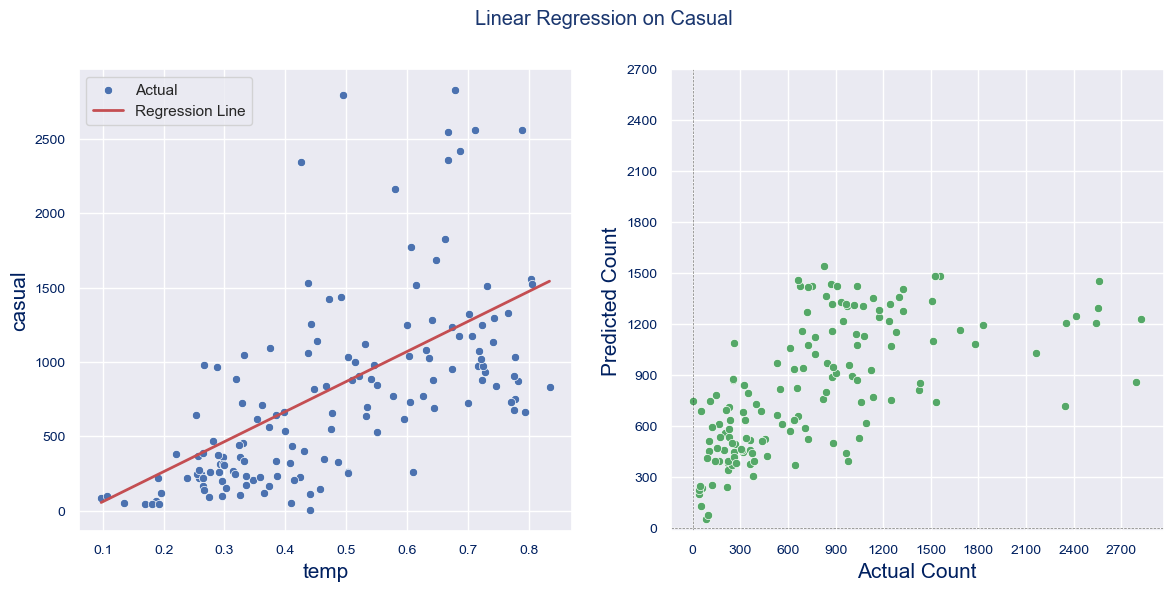

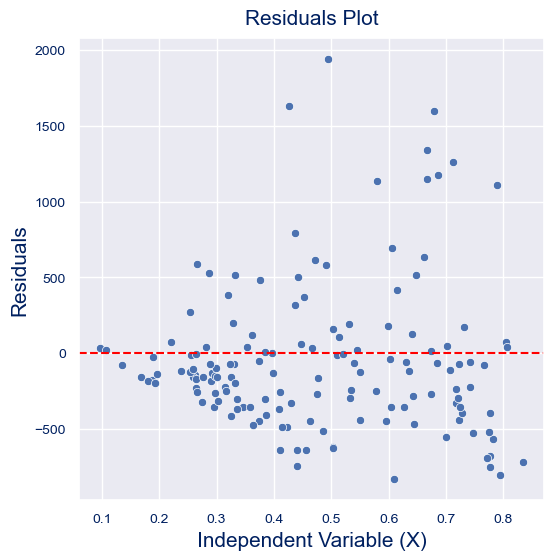

*** Linear Regression ***
>>> Registered    

Root Mean Squared Error:         1398.856
Mean Absolute Error:             1177.089
Mean Absolute Percentage Error:  1.603
R-Squared:                       0.286 

Slope (Coefficient):             4555.284
Intercept:                       1414.633


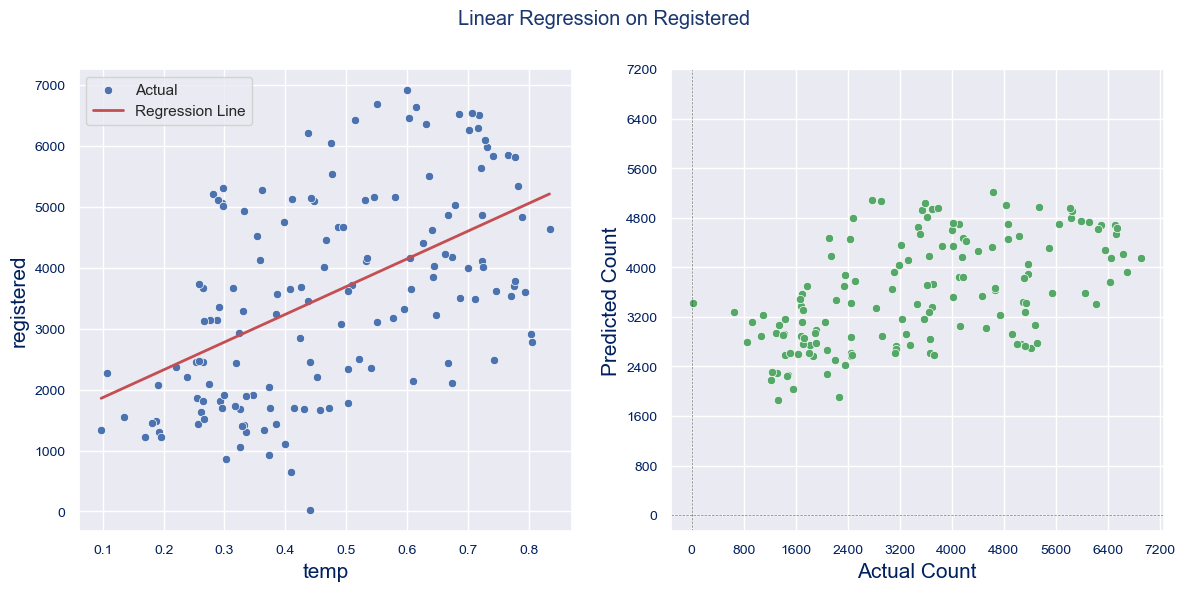

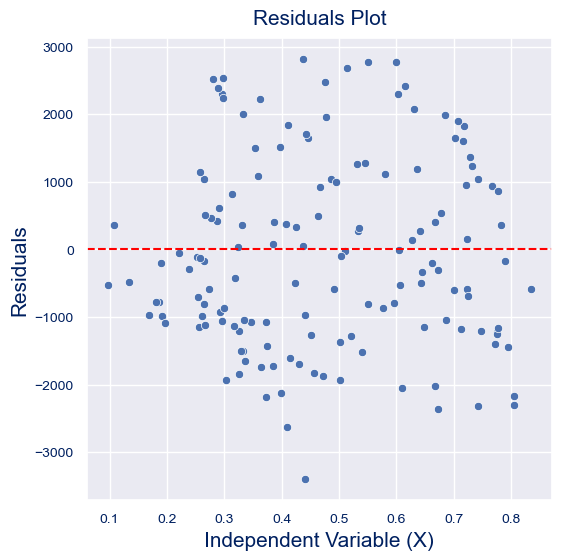

*** Linear Regression ***
>>> Count    

Root Mean Squared Error:         1546.303
Mean Absolute Error:             1291.969
Mean Absolute Percentage Error:  1.689
R-Squared:                       0.404 

Slope (Coefficient):             6575.393
Intercept:                       1272.157


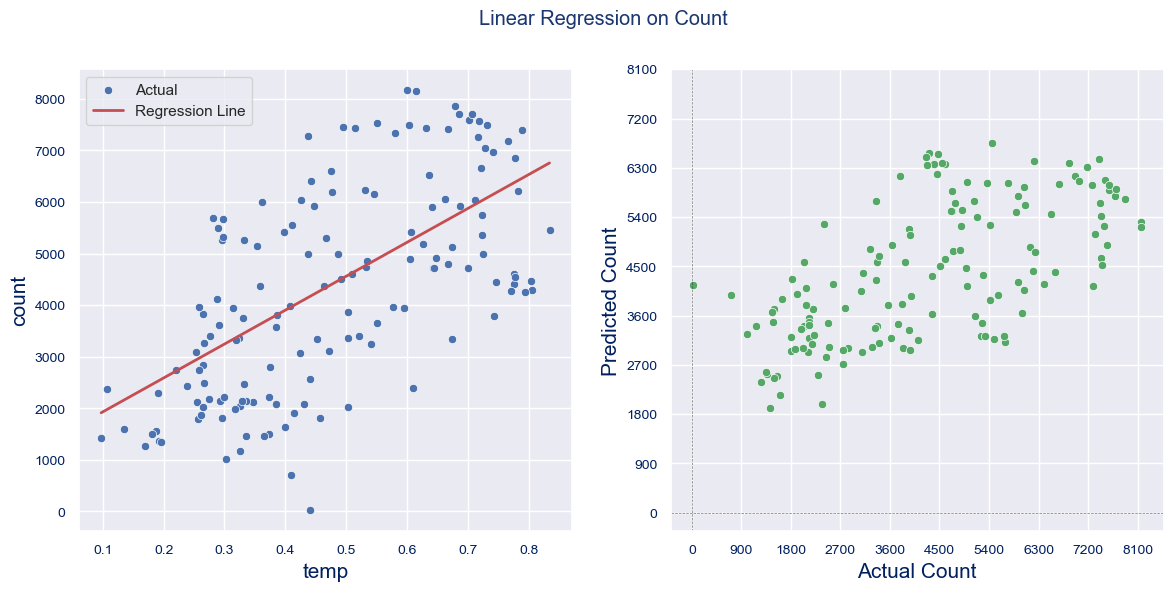

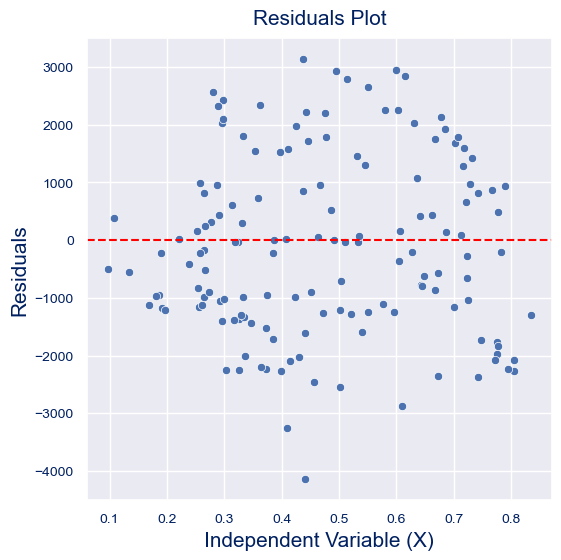

*** Multiple Linear Regression ***
>>> Casual    

Root Mean Squared Error:         299.651
Mean Absolute Error:             227.09
Mean Absolute Percentage Error:  0.804
R-Squared:                       0.77 

Slope (Coefficient):             287.835
Intercept:                       770.674


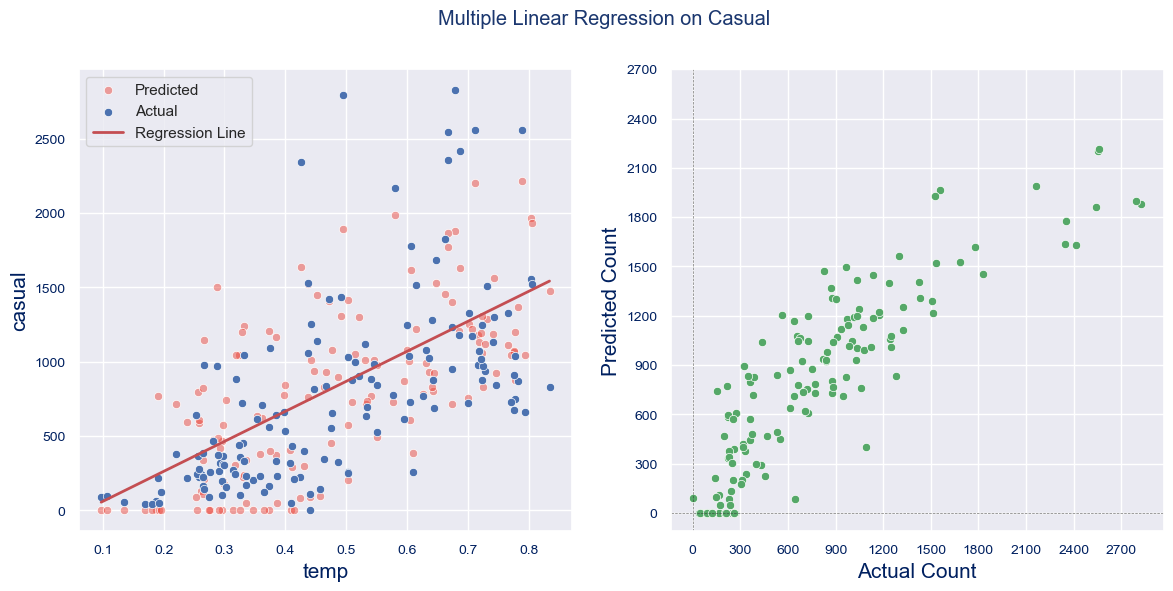

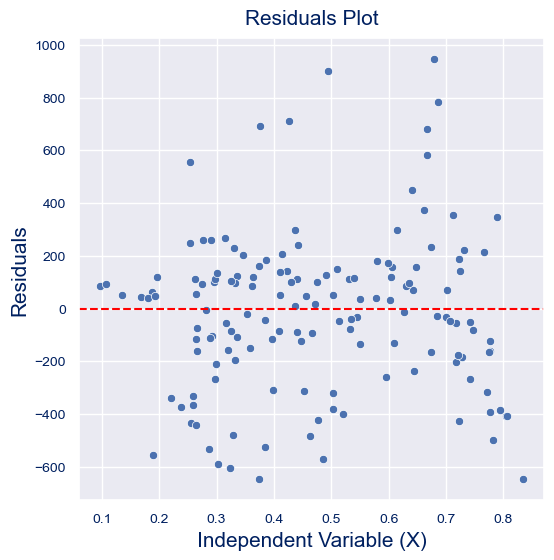

*** Multiple Linear Regression ***
>>> Registered    

Root Mean Squared Error:         729.613
Mean Absolute Error:             558.363
Mean Absolute Percentage Error:  1.4
R-Squared:                       0.806 

Slope (Coefficient):             1694.157
Intercept:                       769.625


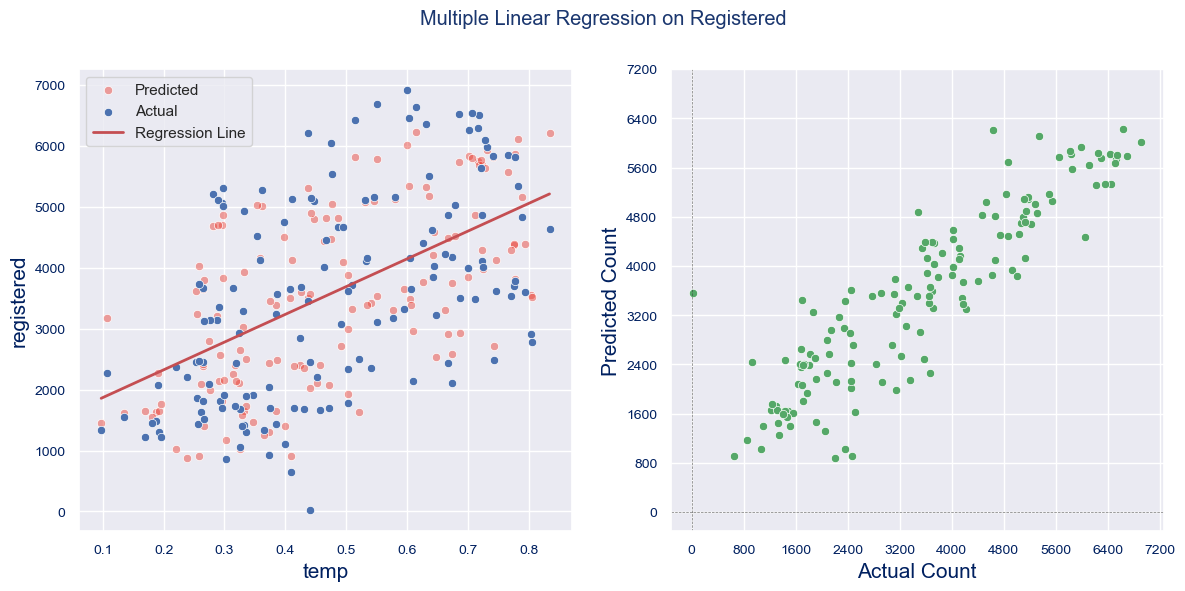

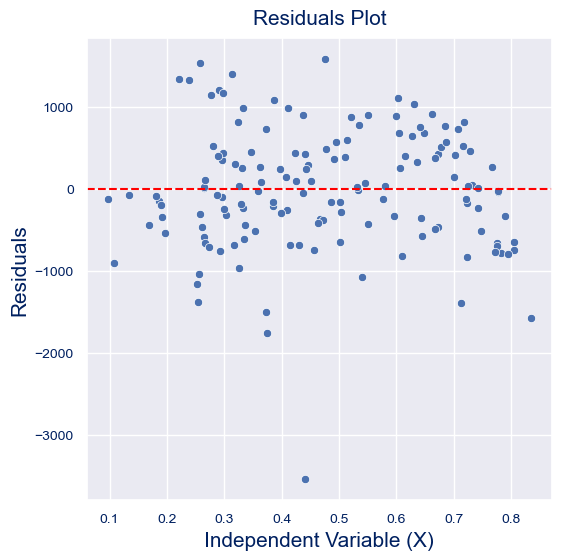

*** Multiple Linear Regression ***
>>> Count    

Root Mean Squared Error:         845.387
Mean Absolute Error:             670.518
Mean Absolute Percentage Error:  1.316
R-Squared:                       0.822 

Slope (Coefficient):             1981.992
Intercept:                       1540.299


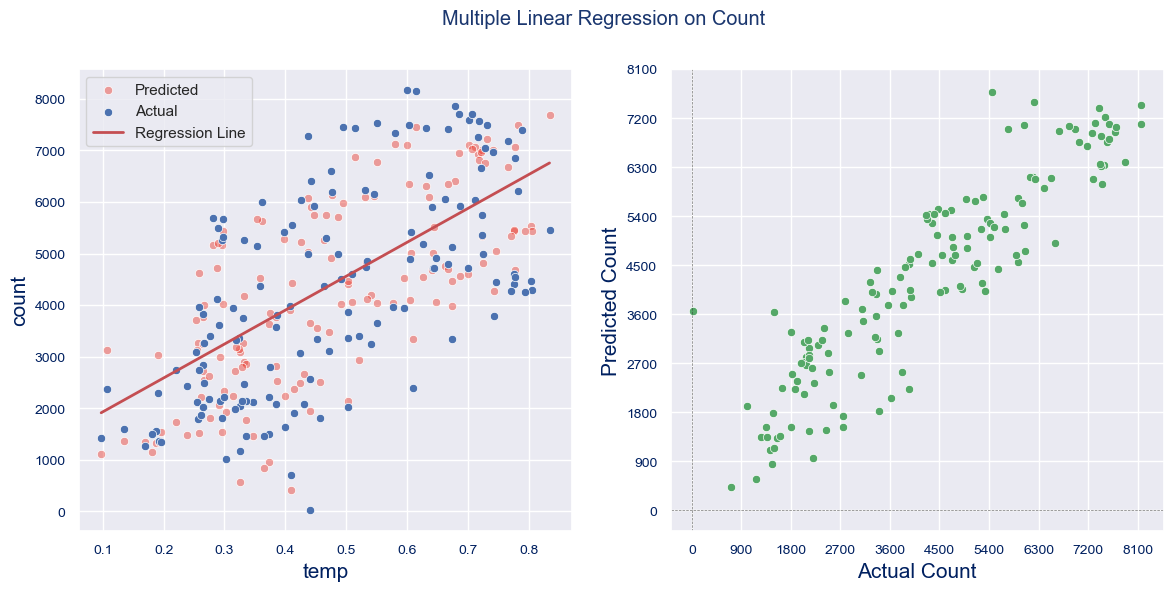

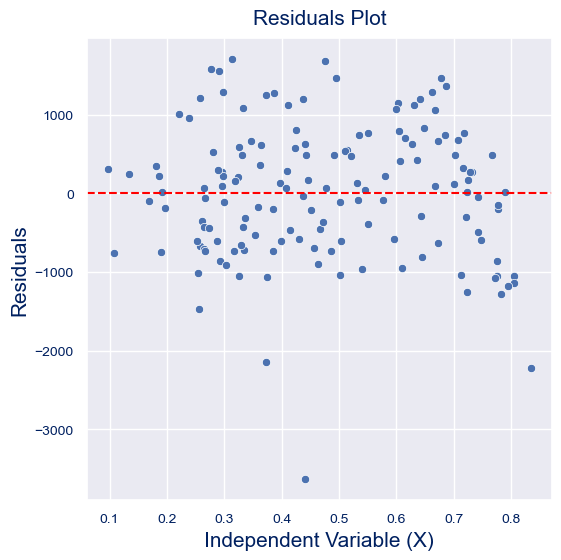

*** Polynomial Regression ***
>>> Casual    

Root Mean Squared Error:         243.424
Mean Absolute Error:             178.914
Mean Absolute Percentage Error:  0.432
R-Squared:                       0.848 



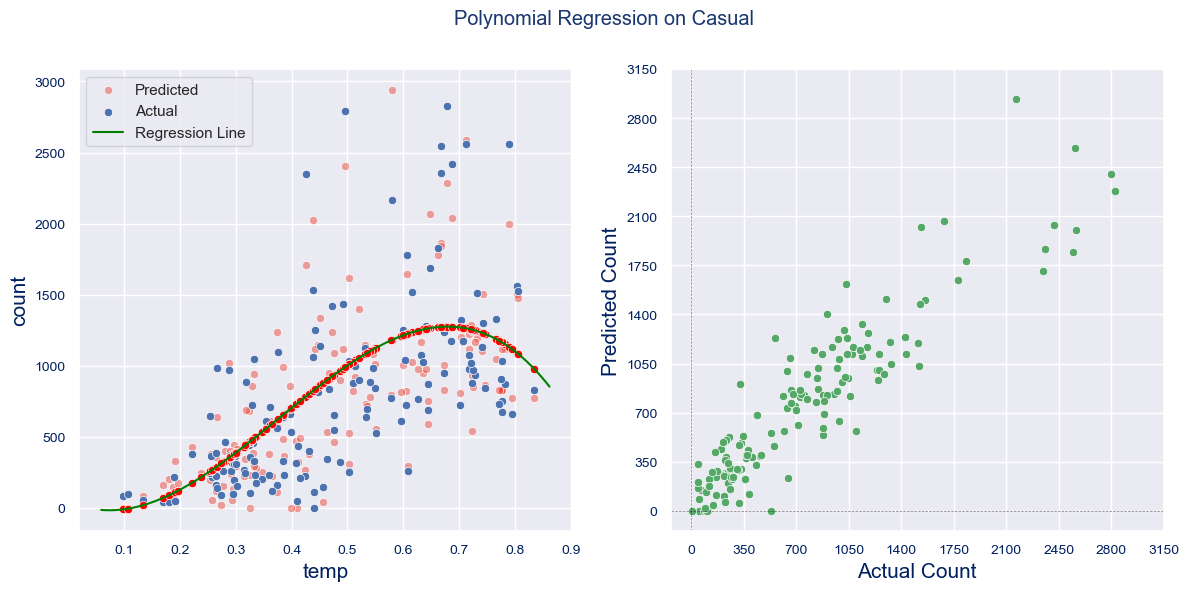

<Figure size 800x600 with 0 Axes>

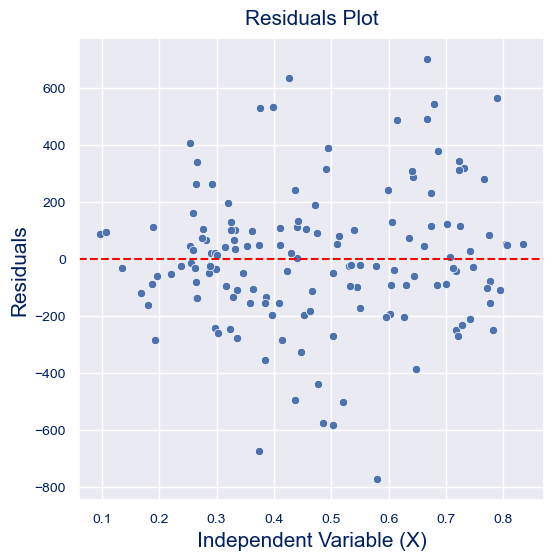

*** Polynomial Regression ***
>>> Registered    

Root Mean Squared Error:         555.254
Mean Absolute Error:             416.918
Mean Absolute Percentage Error:  0.317
R-Squared:                       0.888 



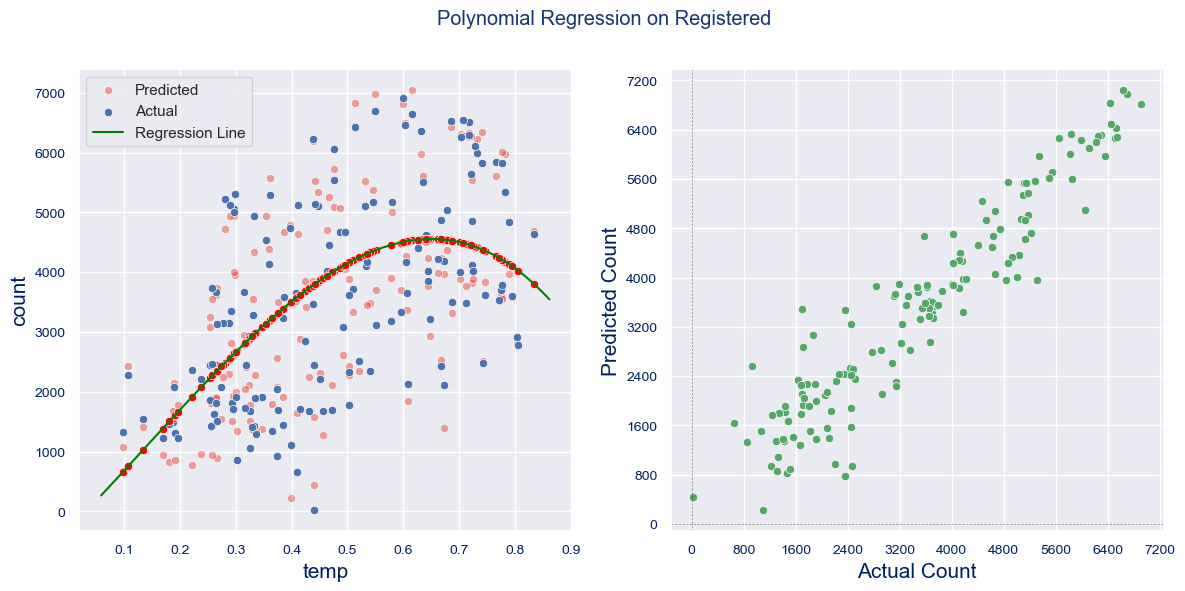

<Figure size 800x600 with 0 Axes>

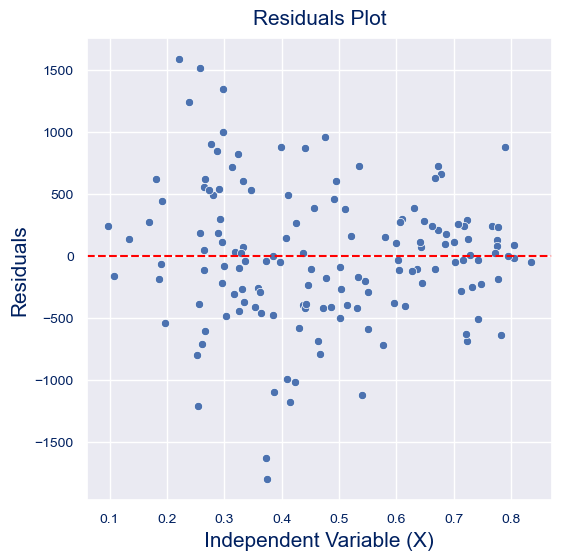

*** Polynomial Regression ***
>>> Count    

Root Mean Squared Error:         664.332
Mean Absolute Error:             516.622
Mean Absolute Percentage Error:  0.29
R-Squared:                       0.89 



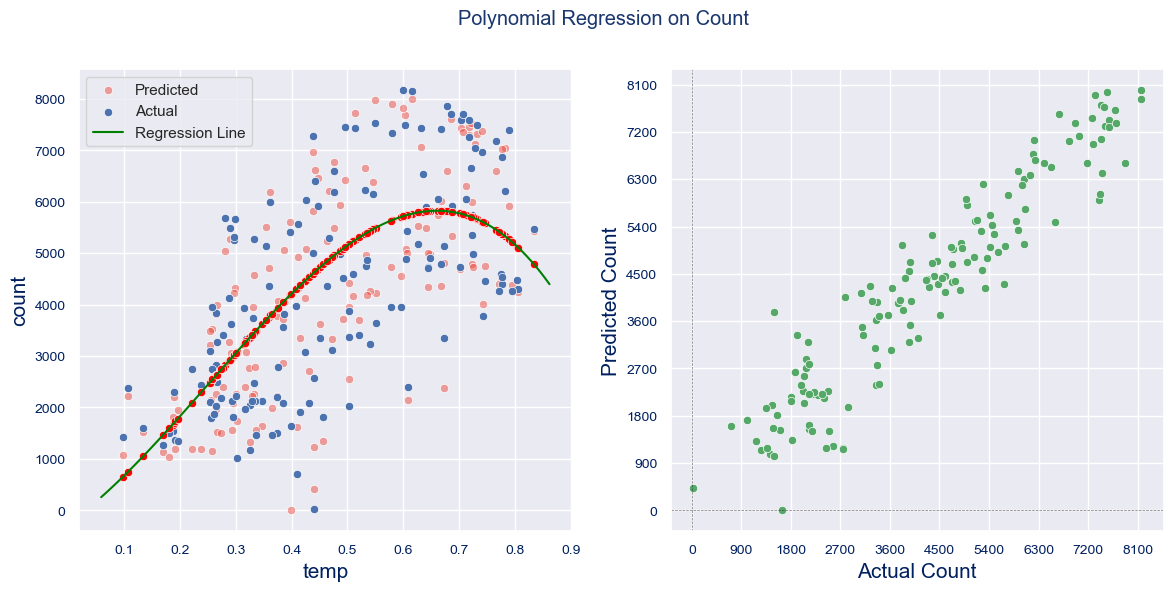

<Figure size 800x600 with 0 Axes>

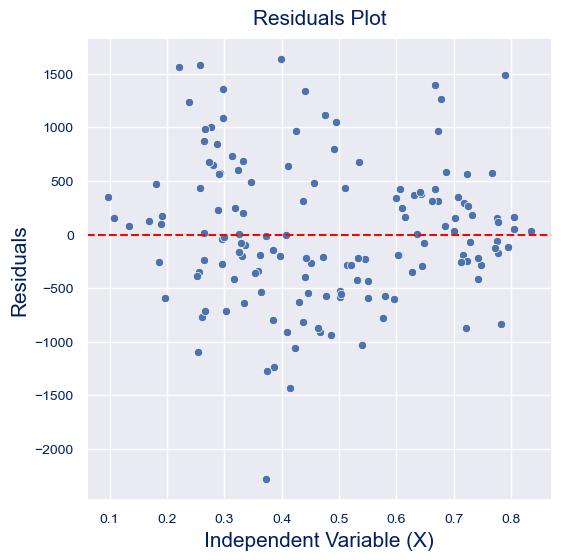

In [30]:
counts = ['casual', 'registered', 'count']
for i in ['line', 'multi', 'poly']:
    for j in counts:
        reg(i, dd_enc, counts, j, feature="temp", do_rfe=False, do_vif=False, pos_target=True)